
# Identifying and Tracking Solar Magnetic Flux Elements with Deep Learning
## Haodi Jiang, Jiasheng Wang, Chang Liu, Ju Jing, Hao Liu, Jason T. L. Wang and Haimin Wang

### Institute for Space Weather Sciences, New Jersey Institute of Technology

# 1. Introduction

Deep learning has drawn significant interest in recent years due to its effectiveness in processing big and complex observational data gathered from diverse instruments. Here we propose a new deep learning method, called SolarUnet, to identify and track solar magnetic flux elements or features in observed vector magnetograms. SolarUnet is applied to data from the 1.6 meter Goode Solar Telescope at the Big Bear Solar Observatory.

In this notebook, we provide an overview of the SolarUnet tool, detailing how it can be used to identify and track solar magnetic flux elements.


# 2. Workflow of SolarUnet

Prepare the runtime environment.

In [ ]:
!git clone https://github.com/HaodiJiang/SolarUnet.git

fatal: destination path 'SolarUnet' already exists and is not an empty directory.


In [ ]:
%cd SolarUnet/

/content/SolarUnet


## 2.1 Data Preparation

Import the pre_processing() function from the solarunet module.

Convert the SWAMIS 3-class masks to 2-class masks for model training. You may put your data into this directory.


In [ ]:
from solarunet import pre_processing
input_path = 'data/exmaple_data_preprocess/3_class/'
output_path = 'data/exmaple_data_preprocess/2_class/'
pre_processing(input_path, output_path)

intgr_180607_161752.fts
intgr_180607_161904.fts


## 2.2 Model Training and Predicting

You may train the model with your own data or directly use the pretrained model for prediction and feature tracking. Here, we show how to train the model using the data prepared in Section 2.1.

### 2.2.1 Training with Default Data and Predicting

Import the model_training(), model_predicting() functions from the solarunet module.

The model is trained with the data prepared in Section 2.1 and tested on the given magnetorgrams. Please make sure your input data is at the given directory or you may create your own directory and modify the path. The predicted results will be saved in the given path.


In [ ]:
from solarunet import model_training, model_predicting
input_path ='data/magnetic/'
output_path ='results/predicted_mask/'
model_training(input_path)
model_predicting(input_path, output_path)

#### 2.2.2 Predicting with the Pretrained Model

Import the model_predicting() function from the solarunet module.

Predict the binary masks of the given magnetograms by using the pretrained model.
We set the 3rd argument of model_predicting() as True.
The predicted results will be saved in the given path

In [ ]:
from solarunet import model_predicting
input_path ='data/magnetic/'
output_path ='results/predicted_mask/'
model_predicting(input_path, output_path, pretrain=True)

3/3 [==============================] - 13s 4s/step
Prediction on the given data done


# **Interpretability using GradCAM**

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('pretrained_model/solarUnet_magnetic.hdf5')
from keras.layers import Conv2D
conv_layer_names = []
for layer in model.layers:
  if isinstance(layer,Conv2D):
    conv_layer_names.append(layer.name)
print(conv_layer_names)


['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_18', 'conv2d_19', 'conv2d_20', 'conv2d_21', 'conv2d_22', 'conv2d_23']


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
img_path='data/magnetic/test/frame_1.png'
img = Image.open(img_path)
img = img.resize((720, 720))
img = np.array(img)
img = img / 255.0
input_tensor = tf.reshape(img, (1, 720, 720, 1))
input_tensor.shape


TensorShape([1, 720, 720, 1])

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

def gradcam(model, image, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, 1]
    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam /= np.max(cam)
    heatmap = cv2.resize(cam.numpy(), (image.shape[2], image.shape[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(image[0]), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)
    return overlay


In [ ]:
overlay = gradcam(model, input_tensor, 'conv2d_23')

**Original Image**

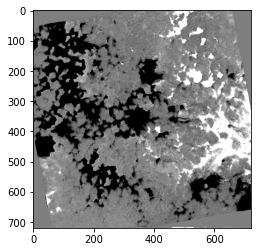

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Image.open(img_path),cmap="gray")

**Class Activation Map**

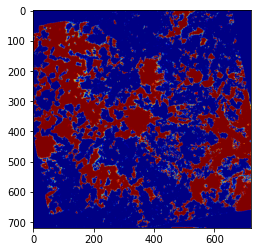

In [ ]:
plt.imshow(overlay)

### 2.3 Postprocessing Data

Import the post_processing() and plot_mask() functions from the solarunet module.

Convert the predicted binary masks to 3-class masks and use the plot_mask() function to draw the SolarUnet
masks of the testing magnetorgrams.

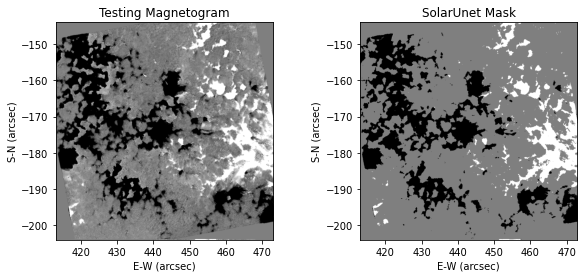

In [ ]:
from solarunet import post_processing
from solarunet import plot_mask
%matplotlib inline
post_processing()
plot_mask()

### 2.4 Magnetic Tracking

Import the magnetic_tracking() function from the magnetic_tracking module.

Magnetic tracking algorithms are performed on the three consecutive testing magnetograms. An option of saving feature lifetime was provided by the 3rd argument of the magnetic_tracking() function. The tracking results will be saved at the given path.


In [ ]:
from magnetic_tracking import magnetic_tracking
input_path = 'results/processed_data_for_tracking/'
output_path = 'results/tracking_results/'
magnetic_tracking(input_path, output_path)
# lifetime_path = 'data/statistics_analysis/lifetime'
# magnetic_tracking(input_path, output_path, lifetime_path)

============magnetic tracking start============
-----------------process frame 1------------------
-----------------process frame 2------------------
-----------------process frame 3------------------
-----------------Done------------------


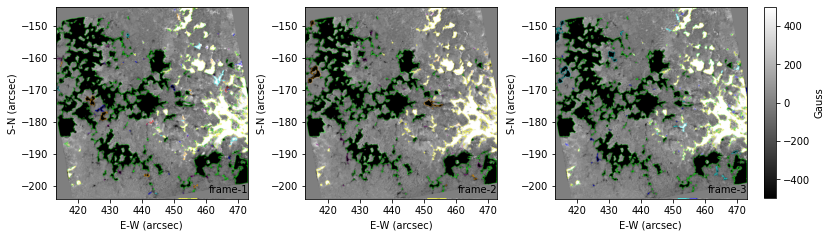

In [ ]:
from solarunet import plot_tracking_results
%matplotlib inline
plot_tracking_results()

### 2.5 Statistics Analysis
Import the analysis() functon from the statistics_analysis module.

The statistics analysis in this work is demoed as follows:

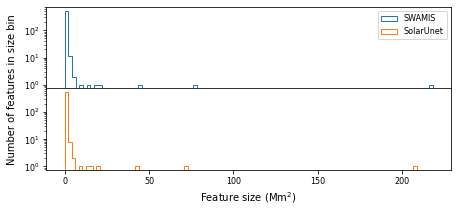

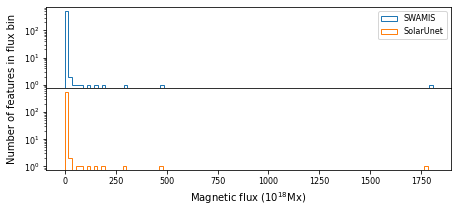

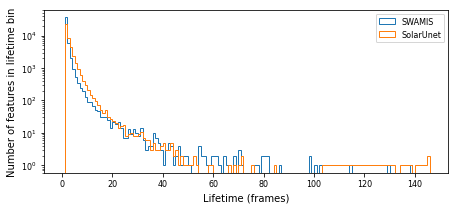

In [ ]:
from statistics_analysis import analysis
%matplotlib inline
analysis()

## 3. Conclusion

We develop a deep learning method, SolarUnet, for tracking signed magnetic flux elements (features) and detecting magnetic events in observed vector magnetograms. We apply the SolarUnet tool to data from the 1.6 meter Goode Solar Telescope (GST) at the Big Bear Solar Observatory (BBSO). The tool is able to identify the magnetic features and detect three types of events, namely disappearance, merging and cancellation, in the death category and three types of events, namely appearance, splitting and emergence, in the birth category. We use the BBSO/GST images to illustrate how our tool works on feature identification and event detection, and compares with the widely used SWAMIS tool.

## Acknowledgment

We thank the BBSO/GST team for providing the data used in this study.
This work was supported by US NSF grants AGS-1927578 and AGS-1954737. C.L. and H.W.
acknowledge the support of NASA under grants NNX16AF72G,
80NSSC18K0673, and 80NSSC18K1705.